In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import numpy as np

import jax
import equinox as eqx
from omegaconf import OmegaConf


In [3]:
import os
import pickle
from sklearn.model_selection import train_test_split
load_path = os.path.join('OriginalData', 'dataset.pkl')
    # 从本地文件夹加载 dataset
with open(load_path, 'rb') as f:
    loaded_dataset = pickle.load(f)

dataset_name = "F4_63_T1"
dataset = loaded_dataset[dataset_name]
x_train, x_test= train_test_split(dataset['x'], test_size=0.2, random_state=42)
    

(244, 1751, 3)


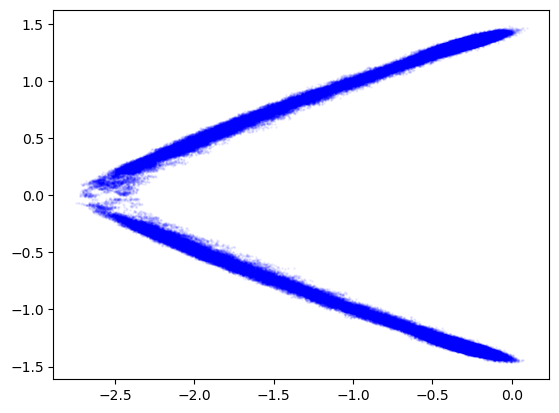

In [4]:
x_test_np = np.array(x_test)
print(x_test_np.shape) 
import matplotlib.pyplot as plt
plt.scatter(x_test_np[:,:, 0], x_test_np[:,:, 1], s=1, c='blue', alpha=0.05)

In [18]:
from utils_reduced_polymer import build_OnsagerNetHD2_scale


data_set_key = "F4_63_T1"

def var_V(data_set_key):
    dataset = loaded_dataset[data_set_key]
    x_train, x_test= train_test_split(dataset['x'], test_size=0.2, random_state=42)
    V=[]
    x_test_np = np.array(x_test)
    x_test_np=(x_test_np[:,:]).reshape(-1, 3)

    def dvdx_net(net):
        def dvdx(x, args):
            return jax.grad(net.potential, argnums=0)(x, args)
        return dvdx


    for seed in [0,1, 12, 123]:
        path =  f"outputs/main{seed}_HD2"
        config = OmegaConf.load(os.path.join(path, ".hydra/config.yaml"))
        model_template = build_OnsagerNetHD2_scale(config) 
        net = eqx.tree_deserialise_leaves(os.path.join(path,data_set_key + '/model.eqx'), model_template)
        V.append(jax.vmap(dvdx_net(net), (0, None))(x_test_np, [config.temperature]))
    V_np = np.array(V)
    var_V = np.var(V_np, axis=0)
    mean_V = np.mean(V_np, axis=0)**2
    print(((var_V.sum(axis=1))/(mean_V.sum(axis=1))).mean())
    return V, (((var_V.sum(axis=1))/(mean_V.sum(axis=1))).mean())
data_set_key_list=["F23_10_T1", "F16_20_T1", "F11_60_T1", 
                       "F4_63_T1", "F3_93_T1", "F2_78_T1", "F2_31_T1", "F1_62_T1"
                  ]

for data_set_key in data_set_key_list:
    print(data_set_key)
    V, var= var_V(data_set_key)

F23_10_T1
0.0028984302
F16_20_T1
0.0083135525
F11_60_T1
0.014233
F4_63_T1
0.0017721386
F3_93_T1
0.0020314786
F2_78_T1
0.008066802
F2_31_T1
0.004104086
F1_62_T1
0.005100194
